In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time

### 导入数据

In [2]:
df = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)

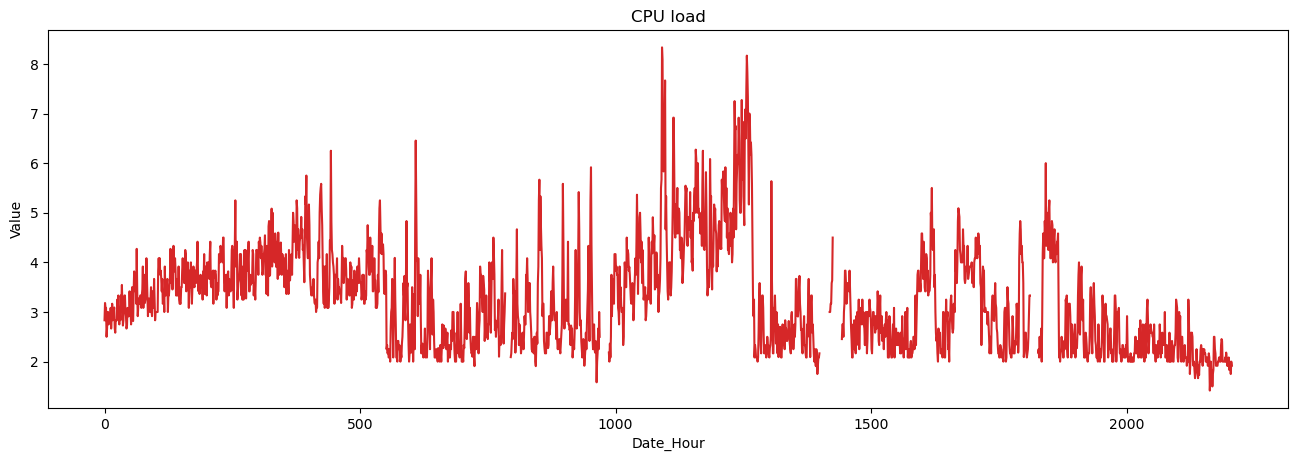

In [3]:
# Draw Plot-----绘图函数
def plot_df(df, x, y, title="", xlabel='Date_Hour', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y= df["主机CPU平均负载"], title='CPU load')

### 缺失值填充

In [4]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out
# 使用k-近邻法填补缺失值
df["主机CPU平均负载"] = knn_mean(df["主机CPU平均负载"], 24)

### 测试集和训练集

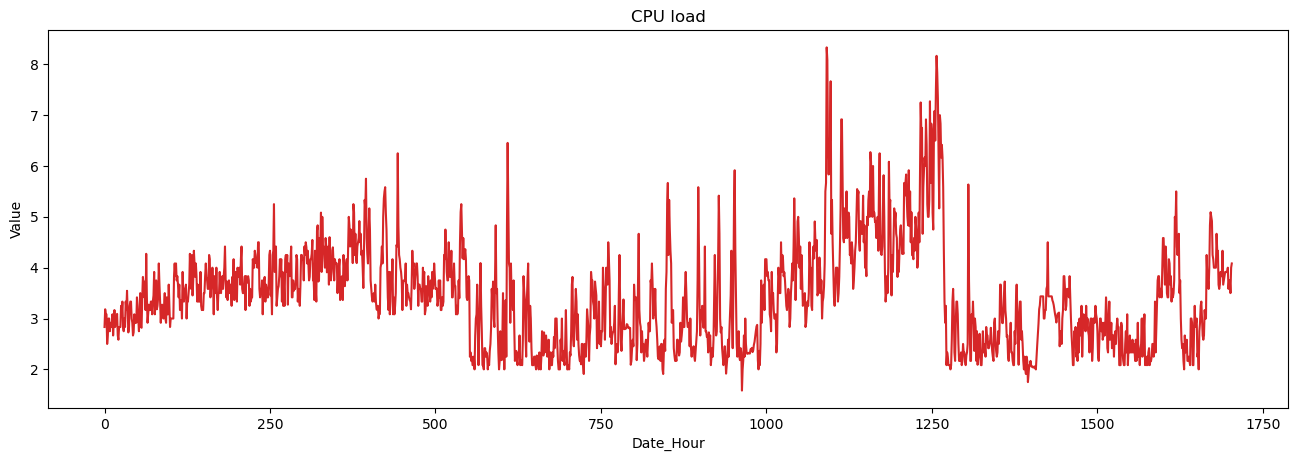

In [5]:
train_data = df["主机CPU平均负载"][0:1704]
test_data = df["主机CPU平均负载"][1704:]
plot_df(df, x=df.index[0:1704], y= train_data, title='CPU load')

### 归一化

In [6]:
max_value = train_data.max(axis=0, skipna=True)
min_value = train_data.min(axis=0, skipna=True)
scalar = max_value - min_value
for i in range(len(train_data)):
    train_data[i]=(train_data[i]-min_value)/scalar
# datas = list(map(lambda x: (x-min_value) / scalar, train_data[:,0]))
# plt.plot(df["日期"], train_data)
# plot_df(df, x=df.index[0:1704], y= train_data, title='CPU load')

In [7]:
for i in range(len(test_data)):
    test_data[i+1704]=(test_data[i+1704]-min_value)/scalar
# plot_df(df, x=df.index[1704:], y= test_data, title='CPU load')

In [8]:
frames = [train_data, test_data]

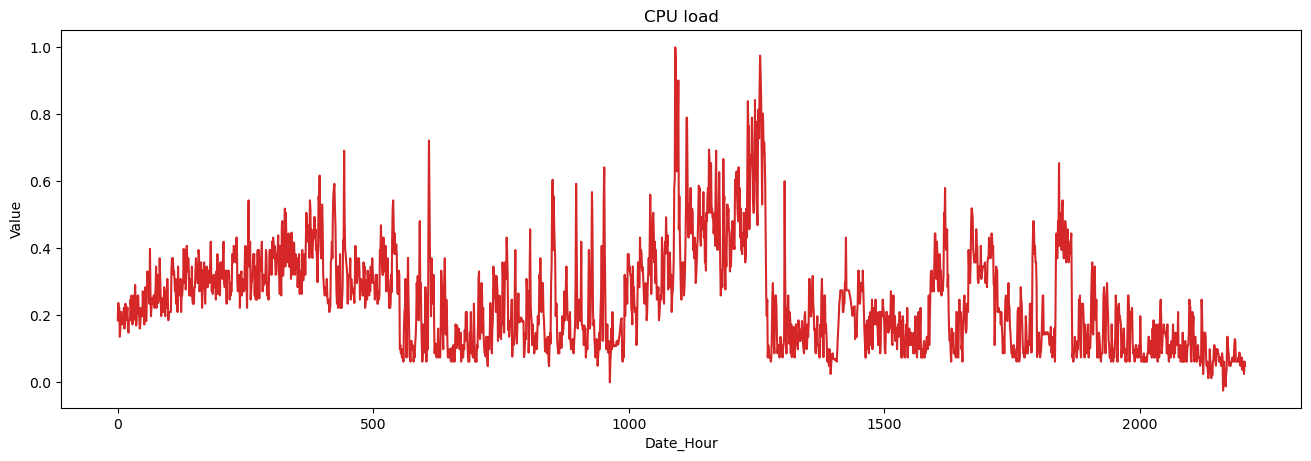

In [9]:
timeSeries = pd.concat(frames)
plot_df(df, x=df.index, y= timeSeries, title='CPU load')

In [10]:
dataframe = pd.DataFrame()
num_hour = 168
for i in range(num_hour,0,-1):
    dataframe['t-'+str(i)] = timeSeries.shift(i)

dataframe['t'] = timeSeries.values
dataframe

,t-168,t-167,t-166,t-165,t-164,t-163,t-162,t-161,t-160,t-159,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.185185
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.185185,0.236815
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.185185,0.236815,0.222222
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.185185,0.236815,0.222222,0.222222
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.185185,0.236815,0.222222,0.222222,0.135807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,0.111111,0.061733,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,...,0.074074,0.061733,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733
2203,0.061733,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,...,0.061733,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393
2204,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,0.148148,...,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393,0.024696
2205,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,0.148148,0.148148,...,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393,0.024696,0.061733


In [11]:
dataframe = dataframe[num_hour+1:]
dataframe

,t-168,t-167,t-166,t-165,t-164,t-163,t-162,t-161,t-160,t-159,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
169,0.236815,0.222222,0.222222,0.135807,0.160504,0.209881,0.209881,0.172844,0.197541,0.196415,...,0.271615,0.296296,0.320993,0.358030,0.320993,0.222222,0.333333,0.308652,0.283956,0.358030
170,0.222222,0.222222,0.135807,0.160504,0.209881,0.209881,0.172844,0.197541,0.196415,0.185185,...,0.296296,0.320993,0.358030,0.320993,0.222222,0.333333,0.308652,0.283956,0.358030,0.271615
171,0.222222,0.135807,0.160504,0.209881,0.209881,0.172844,0.197541,0.196415,0.185185,0.222222,...,0.320993,0.358030,0.320993,0.222222,0.333333,0.308652,0.283956,0.358030,0.271615,0.234578
172,0.135807,0.160504,0.209881,0.209881,0.172844,0.197541,0.196415,0.185185,0.222222,0.160504,...,0.358030,0.320993,0.222222,0.333333,0.308652,0.283956,0.358030,0.271615,0.234578,0.283956
173,0.160504,0.209881,0.209881,0.172844,0.197541,0.196415,0.185185,0.222222,0.160504,0.197541,...,0.320993,0.222222,0.333333,0.308652,0.283956,0.358030,0.271615,0.234578,0.283956,0.283956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,0.111111,0.061733,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,...,0.074074,0.061733,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733
2203,0.061733,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,...,0.061733,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393
2204,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,0.148148,...,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393,0.024696
2205,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,0.148148,0.148148,...,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393,0.024696,0.061733


In [12]:
dataframe3 = dataframe.corr()
Series1 = dataframe3["t"].sort_values(ascending=False)
len(Series1[1:15].index)

14

In [13]:
# dataframe_mean= pd.DataFrame()
# for i in range(7):
#     dataframe_temp = pd.DataFrame()
#     dataframe_temp = dataframe.iloc[:,i*24:-1]
#     dataframe_mean["前"+str(7-i)+"天"] = dataframe_temp.mean(axis=1, skipna=True)
# dataframe_mean["t"] = dataframe["t"]

In [14]:
# RFE选择的42个
# dataframe2 = dataframe.loc[:,["t-168","t-166","t-164","t-163","t-161","t-156","t-152","t-148","t-144","t-141","t-137","t-20","t-118","t-110","t-95","t-90","t-76","t-72","t-71","t-53","t-49","t-48","t-47","t-39","t-34","t-26","t-24","t-23","t-22","t-18","t-16","t-15","t-13","t-12","t-8","t-7","t-6","t-5","t-4","t-3","t-2","t-1"]]
# RFE选择的84个
# dataframe2 = dataframe.loc[:,["t-168","t-167","t-166","t-165","t-164","t-163","t-162","t-161","t-157","t-156","t-152","t-150","t-149","t-148","t-147","t-144","t-143","t-142","t-141","t-137","t-135","t-130","t-126","t-124","t-120","t-119","t-118","t-110","t-107","t-101","t-96","t-95","t-94","t-90","t-86","t-84","t-83","t-80","t-77","t-76","t-74","t-72","t-71","t-70","t-67","t-66","t-64","t-56","t-53","t-51","t-49","t-48","t-47","t-46","t-44","t-39","t-35","t-34","t-31","t-27","t-26","t-24","t-23","t-22","t-21","t-20","t-19","t-18","t-17","t-16","t-15","t-14","t-13","t-12","t-10","t-9","t-8","t-7","t-6","t-5","t-4","t-3","t-2","t-1"]]
# corr选择的
dataframe2 = dataframe.loc[:,Series1[1:15].index]
dataframe2["t"] = dataframe["t"]
dataframe_temp = dataframe2.loc[337:,:]
dataframe_temp

,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-24,t-23,t-9,t-25,t-22,t-18,t
337,0.344563,0.419763,0.444444,0.358030,0.384963,0.419763,0.419763,0.506178,0.398430,0.438844,0.345689,0.382726,0.320993,0.296296,0.358030
338,0.358030,0.344563,0.419763,0.444444,0.358030,0.384963,0.419763,0.419763,0.438844,0.320993,0.506178,0.398430,0.320993,0.259259,0.419763
339,0.419763,0.358030,0.344563,0.419763,0.444444,0.358030,0.384963,0.419763,0.320993,0.320993,0.419763,0.438844,0.263748,0.465778,0.308652
340,0.308652,0.419763,0.358030,0.344563,0.419763,0.444444,0.358030,0.384963,0.320993,0.263748,0.419763,0.320993,0.407407,0.481481,0.446919
341,0.446919,0.308652,0.419763,0.358030,0.344563,0.419763,0.444444,0.358030,0.263748,0.407407,0.384963,0.320993,0.296296,0.317630,0.345689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,0.037037,0.074074,0.049393,0.061733,0.049393,0.074074,0.088667,0.061733,0.049393,0.061733,0.074074,0.049393,0.061733,0.061733,0.061733
2203,0.061733,0.037037,0.074074,0.049393,0.061733,0.049393,0.074074,0.088667,0.061733,0.061733,0.061733,0.049393,0.074074,0.111111,0.049393
2204,0.049393,0.061733,0.037037,0.074074,0.049393,0.061733,0.049393,0.074074,0.061733,0.074074,0.088667,0.061733,0.074074,0.129067,0.024696
2205,0.024696,0.049393,0.061733,0.037037,0.074074,0.049393,0.061733,0.049393,0.074074,0.074074,0.074074,0.061733,0.061733,0.123467,0.061733


In [15]:
array = dataframe_temp.values
array

array([[0.34456296, 0.41976296, 0.44444444, ..., 0.32099259, 0.2962963 ,
        0.35802963],
       [0.35802963, 0.34456296, 0.41976296, ..., 0.32099259, 0.25925926,
        0.41976296],
       [0.41976296, 0.35802963, 0.34456296, ..., 0.26374815, 0.46577778,
        0.30865185],
       ...,
       [0.04939259, 0.06173333, 0.03703704, ..., 0.07407407, 0.12906667,
        0.0246963 ],
       [0.0246963 , 0.04939259, 0.06173333, ..., 0.06173333, 0.12346667,
        0.06173333],
       [0.06173333, 0.0246963 , 0.04939259, ..., 0.06173333, 0.06173333,
        0.04939259]])

In [16]:
train_X = torch.Tensor(array[:1536,0:-1].reshape(-1, 7, 2))
train_Y = torch.Tensor(array[:1536,-1].reshape(-1, 1, 1))
train_X.shape

torch.Size([1536, 7, 2])

In [17]:
test_X = torch.Tensor(array[1536:1792,0:-1].reshape(-1, 7, 2))
test_Y = torch.Tensor(array[1536:1792,-1].reshape(-1, 1, 1))
test_X.shape

torch.Size([256, 7, 2])

In [18]:
# train_data_temp = torch.utils.data.TensorDataset(train_X, train_Y)
# test_data_temp = torch.utils.data.TensorDataset(test_X, test_Y)
# train_data = DataLoader(train_data_temp, batch_size=256, shuffle=True, num_workers=1)#训练数据
# test_data = DataLoader(test_data_temp, batch_size=256, shuffle=False, num_workers=2)#测试数据

In [19]:
start = time.time()

### 建立GRU模型

In [20]:
class GRUModel(nn.Module):
    def __init__(self, input_num, hidden_num, output_num):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_num
        # 这里设置了 batch_first=True, 所以应该 inputs = inputs.view(inputs.shape[0], -1, inputs.shape[1])
        # 针对时间序列预测问题，相当于将时间步（seq_len）设置为 1。
        self.GRU_layer = nn.GRU(input_size=input_num, hidden_size=hidden_num, batch_first=True)
        self.output_linear = nn.Linear(hidden_num, output_num)
        self.hidden = None

    def forward(self, x):
        # h_n of shape (num_layers * num_directions, batch, hidden_size)
        # 这里不用显式地传入隐层状态 self.hidden
        x, self.hidden = self.GRU_layer(x) 
        x = x[:,[6],:]
        b, s, h = x.size()
#         print(x.shape)
        x = x.view(-1,h)
#         print(x.shape)
        x = self.output_linear(x)
        x = x.view(b, s, -1)
        return x

model = GRUModel(2, 128, 1)
model

GRUModel(
  (GRU_layer): GRU(2, 128, batch_first=True)
  (output_linear): Linear(in_features=128, out_features=1, bias=True)
)

In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epoch_n = 240

In [22]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(epoch_n):
    var_x = Variable(train_X)
    var_y = Variable(train_Y)
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 5 == 0: # 每 2 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
    ep.append(e+1)
    losses.append(loss.item())
#     break
#     if (e+1)%120 == 0:
#         for p in optimizer.param_groups:
#             p['lr'] *= 0.1
#     lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

print('Finished Training') 

Epoch: 5, Loss: 0.02728
Epoch: 10, Loss: 0.01891
Epoch: 15, Loss: 0.01386
Epoch: 20, Loss: 0.01270
Epoch: 25, Loss: 0.01085
Epoch: 30, Loss: 0.01053
Epoch: 35, Loss: 0.00993
Epoch: 40, Loss: 0.00917
Epoch: 45, Loss: 0.00846
Epoch: 50, Loss: 0.00789
Epoch: 55, Loss: 0.00731
Epoch: 60, Loss: 0.00697
Epoch: 65, Loss: 0.00658
Epoch: 70, Loss: 0.00634
Epoch: 75, Loss: 0.00693
Epoch: 80, Loss: 0.00638
Epoch: 85, Loss: 0.00602
Epoch: 90, Loss: 0.00599
Epoch: 95, Loss: 0.00593
Epoch: 100, Loss: 0.00584
Epoch: 105, Loss: 0.00581
Epoch: 110, Loss: 0.00578
Epoch: 115, Loss: 0.00575
Epoch: 120, Loss: 0.00573
Epoch: 125, Loss: 0.00639
Epoch: 130, Loss: 0.00613
Epoch: 135, Loss: 0.00590
Epoch: 140, Loss: 0.00579
Epoch: 145, Loss: 0.00565
Epoch: 150, Loss: 0.00575
Epoch: 155, Loss: 0.00563
Epoch: 160, Loss: 0.00562
Epoch: 165, Loss: 0.00556
Epoch: 170, Loss: 0.00555
Epoch: 175, Loss: 0.00551
Epoch: 180, Loss: 0.00545
Epoch: 185, Loss: 0.00544
Epoch: 190, Loss: 0.00589
Epoch: 195, Loss: 0.00545
Epoch:

In [23]:
end = time.time()

In [24]:
time = end - start
print(f'运行时长为:{int(time)}s')

运行时长为:47s


In [25]:
# plot_df(df, x=range(epoch_n), y= lr_list, title='LOSS')

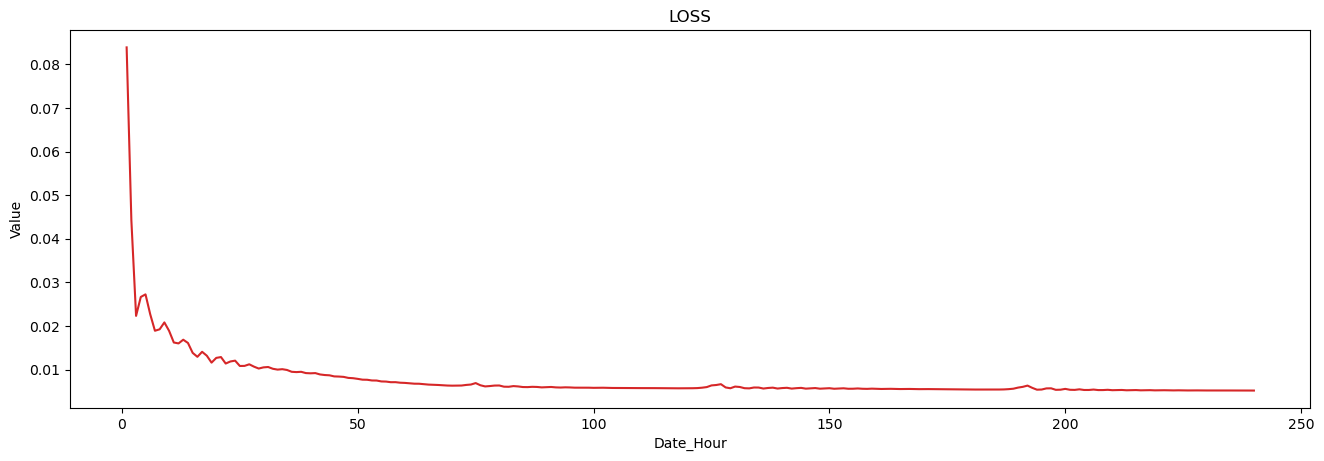

In [26]:
plot_df(df, x=ep, y= losses, title='LOSS')

In [27]:
torch.save(model, 'net.pkl')
model2 = torch.load('net.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type GRUModel. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [28]:
outputs = model2(test_X)
loss = criterion(outputs, test_Y)
loss

tensor(0.0024, grad_fn=<MseLossBackward>)

In [36]:
outputs[0:20]

tensor([0.0896, 0.1007, 0.0906, 0.1365, 0.1256, 0.1186, 0.1394, 0.1205, 0.1721,
        0.2434, 0.2380, 0.2572, 0.1414, 0.1287, 0.2294, 0.2532, 0.2318, 0.1936,
        0.1458, 0.1098], grad_fn=<SliceBackward>)

In [37]:
test_Y[0:20]

tensor([0.1358, 0.0988, 0.1111, 0.0741, 0.0741, 0.1235, 0.0988, 0.1358, 0.2469,
        0.2346, 0.2593, 0.0988, 0.0741, 0.2222, 0.2346, 0.2346, 0.2346, 0.1975,
        0.1235, 0.0741])

In [29]:
outputs = outputs.reshape(256)
y_pred_temp = outputs.detach().numpy().tolist()
# 二维转一维
y_pred = []
for i in range(len(y_pred_temp)):
    y_pred.append(y_pred_temp[i])

In [30]:
num = 256

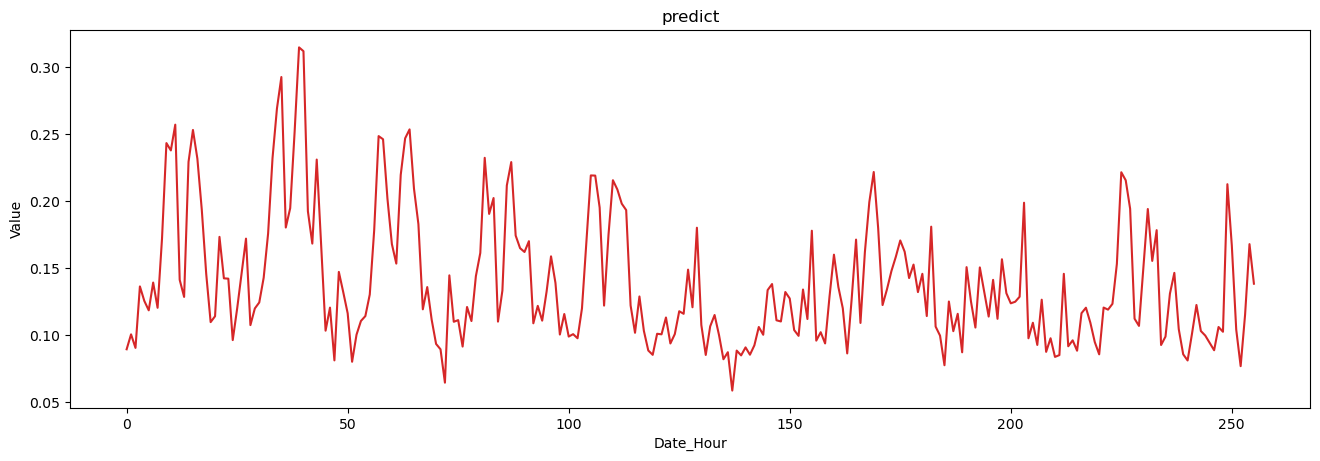

In [31]:
plot_df(df, x=range(num), y= y_pred[0:num], title='predict')

In [32]:
test_Y = test_Y.reshape(256)

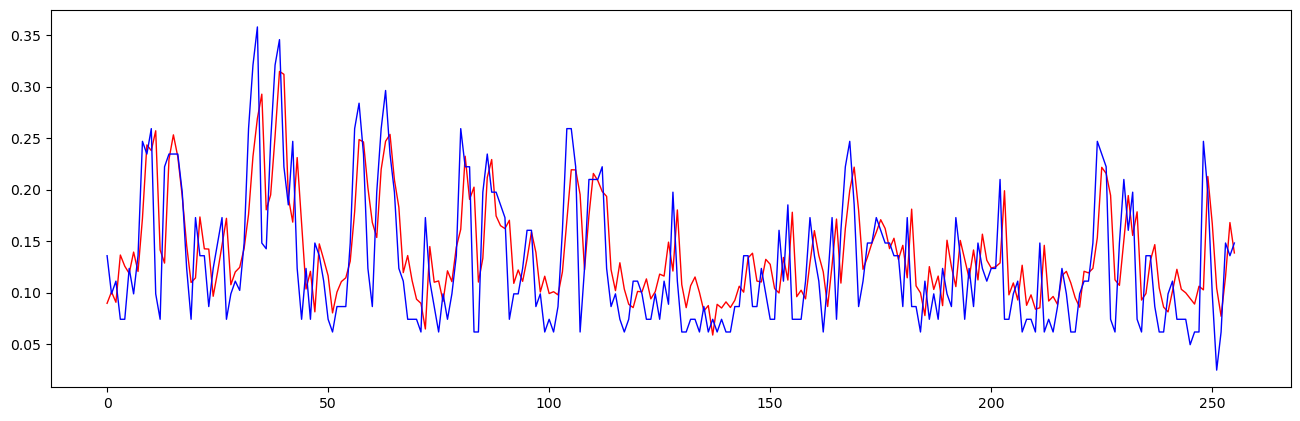

In [33]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), y_pred[0:num], c='red', lw='1')
plt.plot(range(num), test_Y[0:num], c='blue', lw='1')